In [29]:
from os import listdir
from os.path import join
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import random
from scipy import stats
import tensorflow as tf
physical_devices = tf.config.experimental.list_physical_devices('GPU')
print(physical_devices)
# print(tf.test.is_gpu_available()) 
# print(tf.test.is_built_with_cuda())
from tensorflow import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import InputLayer, Dense, LSTM, Dropout, RepeatVector, TimeDistributed
from sklearn.metrics import confusion_matrix
from keras_tuner.tuners import Hyperband
import seaborn as sn

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


In [30]:
# Settings
dataset_path = '..\\Dataset'  # Directory where raw accelerometer data is stored
normal_op_list = ['my steady']
anomaly_op_list = ['fan med', 'fan high',
                  'fan low weight', 'fan med weight', 'fan high weight']

val_ratio = 0.2             # Percentage of samples that should be held for validation set
test_ratio = 0.2            # Percentage of samples that should be held for test set
raw_scale = 1               # Multiply raw values to fit into integers

max_measurements = 128      # Expected number of measurements in each file (truncate to this)

time_steps = 32    # Memory of the lstm

keras_model_name = 'models\\LSTM_model'           # Will be given .h5 suffix
sample_file_name = 'test_samples\\normal_anomaly_samples'  # Will be given .npz suffix
rep_dataset_name = 'test_samples\\normal_anomaly_test_set' # Will be given .npz suffix


In [31]:
# Create list of filenames
def createFilenameList(op_list):
    
    # Extract paths and filenames in each directory
    op_filenames = []
    num_samples = 0
    for index, target in enumerate(op_list):
        samples_in_dir = listdir(join(dataset_path, target))
        samples_in_dir = [join(dataset_path, target, sample) for sample in samples_in_dir]
        op_filenames.append(samples_in_dir)
    
    # Flatten list
    return [item for sublist in op_filenames for item in sublist]

In [32]:
# Create normal and anomaly filename lists
normal_op_filenames = createFilenameList(normal_op_list)
anomaly_op_filenames = createFilenameList(anomaly_op_list)
print('Number of normal samples:', len(normal_op_filenames))
print('Number of anomaly samples:', len(anomaly_op_filenames))

Number of normal samples: 527
Number of anomaly samples: 2926


In [33]:
# Shuffle lists
random.shuffle(normal_op_filenames)
random.shuffle(anomaly_op_filenames)

In [34]:
# Calculate validation and test set sizes
val_set_size = int(len(normal_op_filenames) * val_ratio)
test_set_size = int(len(normal_op_filenames) * test_ratio)

In [35]:
# Break dataset apart into train, validation, and test sets
num_samples = len(normal_op_filenames)
filenames_val = normal_op_filenames[:val_set_size]
filenames_test = normal_op_filenames[val_set_size:(val_set_size + test_set_size)]
filenames_train = normal_op_filenames[(val_set_size + test_set_size):]

# Print out number of samples in each set
print('Number of training samples:', len(filenames_train))
print('Number of validation samples:', len(filenames_val))
print('Number of test samples:', len(filenames_test))

# Check that our splits add up correctly
assert(len(filenames_train) + len(filenames_val) + len(filenames_test)) == num_samples

Number of training samples: 317
Number of validation samples: 105
Number of test samples: 105


In [37]:
# Function: loop through filenames, creating feature sets
# Convert input data into 3-D array combining TIME_STEPS.
# The shape of the array should be [samples, TIME_STEPS, features], as required for LSTM network.
import math

def create_sequences(filenames):
    x_out = []
    for file in filenames:        
        sample = np.genfromtxt(file, delimiter=',')
        
        # Truncate sample
        for i in range(0, math.floor((max_measurements/time_steps)), time_steps):
            x_out.append(sample[i*time_steps:((i+1)*time_steps)])
            
    return np.array(x_out)

In [38]:
# Create training, validation, and test sets
x_train = create_sequences(filenames_train)
print('Extracted features from training set. Shape:', x_train.shape)
x_val = create_sequences(filenames_val)
print('Extracted features from validation set. Shape:', x_val.shape)
x_test = create_sequences(filenames_test)
print('Extracted features from test set. Shape:', x_test.shape)

Extracted features from training set. Shape: (317, 32, 3)
Extracted features from validation set. Shape: (105, 32, 3)
Extracted features from test set. Shape: (105, 32, 3)


In [43]:
# Build model
# Reference from: https://towardsdatascience.com/time-series-of-price-anomaly-detection-with-lstm-11a12ba4f6d9
model = Sequential()
model.add(InputLayer(input_shape=(x_train.shape[1], x_train.shape[2])))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(LSTM(16, activation='relu', return_sequences=False))
model.add(RepeatVector(x_train.shape[1]))   # Repeats the inputs time_samples times
model.add(LSTM(16, activation='relu', return_sequences=True))
model.add(LSTM(32, activation='relu', return_sequences=True))
model.add(TimeDistributed(Dense(x_train.shape[2]))) # Get the output

# Add training parameters to model
model.compile(loss='mean_squared_error', optimizer='adam', metrics = ['mse'])

# Display model
model.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_4 (LSTM)               (None, 32, 32)            4608      
                                                                 
 lstm_5 (LSTM)               (None, 16)                3136      
                                                                 
 repeat_vector_1 (RepeatVect  (None, 32, 16)           0         
 or)                                                             
                                                                 
 lstm_6 (LSTM)               (None, 32, 16)            2112      
                                                                 
 lstm_7 (LSTM)               (None, 32, 32)            6272      
                                                                 
 time_distributed_1 (TimeDis  (None, 32, 3)            99        
 tributed)                                            

In [44]:
# Train model (note Y labels are same as inputs, X)
from tabnanny import verbose

history = model.fit(x_train,
                   x_train,
                   epochs=50,
                   batch_size=32,
                   validation_split=0.1,
                   validation_data=(x_val, x_val),
                   verbose = 1)

Epoch 1/50
10/10 [==============================] - 10s 500ms/step - loss: 0.3001 - mse: 0.3001 - val_loss: 0.2641 - val_mse: 0.2641
Epoch 2/50
10/10 [==============================] - 4s 427ms/step - loss: 0.2061 - mse: 0.2061 - val_loss: 0.1442 - val_mse: 0.1442
Epoch 3/50
10/10 [==============================] - 4s 423ms/step - loss: 0.1086 - mse: 0.1086 - val_loss: 0.0737 - val_mse: 0.0737
Epoch 4/50
10/10 [==============================] - 4s 415ms/step - loss: 0.0575 - mse: 0.0575 - val_loss: 0.0477 - val_mse: 0.0477
Epoch 5/50
10/10 [==============================] - 4s 443ms/step - loss: 0.0438 - mse: 0.0438 - val_loss: 0.0400 - val_mse: 0.0400
Epoch 6/50
10/10 [==============================] - 4s 417ms/step - loss: 0.0377 - mse: 0.0377 - val_loss: 0.0346 - val_mse: 0.0346
Epoch 7/50
10/10 [==============================] - 4s 420ms/step - loss: 0.0323 - mse: 0.0323 - val_loss: 0.0298 - val_mse: 0.0298
Epoch 8/50
10/10 [==============================] - 4s 424ms/step - loss: 0

In [45]:
test_loss, test_acc = model.evaluate(x_test, x_test)

print("Test accuracy", test_acc)
print("Test loss", test_loss)

4/4 [==============================] - 0s 54ms/step - loss: 4.9231e-06 - mse: 4.9231e-06
Test accuracy 4.923056167172035e-06
Test loss 4.923056167172035e-06


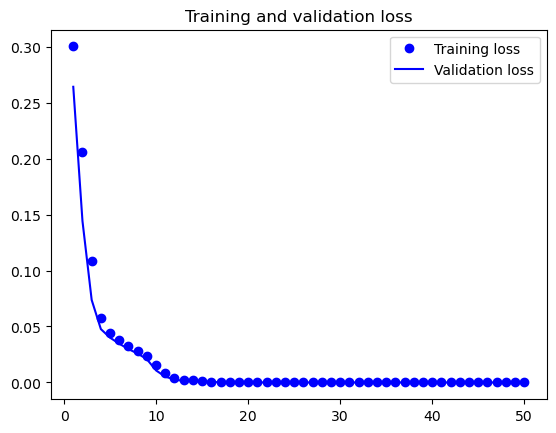

In [46]:
# Plot results
loss = history.history['loss']
val_loss = history.history['val_loss']
epochs = range(1, len(loss) + 1)
plt.figure()
plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()
plt.show()

4/4 [==============================] - 1s 56ms/step
Average MSE for normal validation set: 4.872228661998251e-06
Standard deviation of MSE for normal validation set: 2.082071893875295e-06
Recommended threshold (3x std dev + avg): 1.1118444343624137e-05


(array([[10., 26., 12., 12., 10.,  3.,  7., 10.,  3.,  3.,  3.,  2.,  1.,
          0.,  0.,  1.,  0.,  1.,  0.,  1.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  6.,  6., 15., 24., 19., 17.,
         12.,  3.,  3.,  0.,  0.,  0.,  0.],
        [ 1.,  0., 13., 17., 28., 18., 10.,  8.,  6.,  3.,  0.,  0.,  0.,
          0.,  0.,  1.,  0.,  0.,  0.,  0.]]),
 array([1.32424037e-06, 1.83545389e-06, 2.34666741e-06, 2.85788093e-06,
        3.36909445e-06, 3.88030797e-06, 4.39152149e-06, 4.90273501e-06,
        5.41394853e-06, 5.92516204e-06, 6.43637556e-06, 6.94758908e-06,
        7.45880260e-06, 7.97001612e-06, 8.48122964e-06, 8.99244316e-06,
        9.50365668e-06, 1.00148702e-05, 1.05260837e-05, 1.10372972e-05,
        1.15485108e-05]),
 <a list of 3 BarContainer objects>)

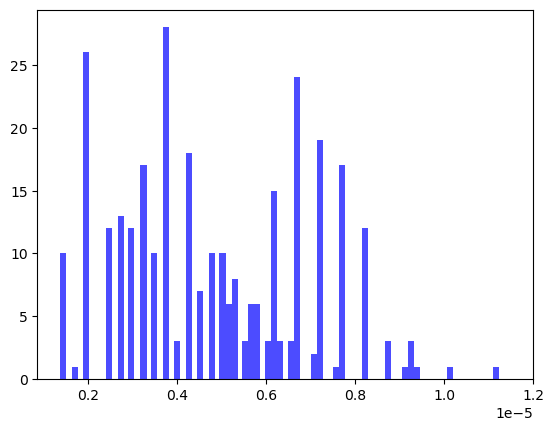

In [47]:
# Calculate MSE from validation set
predictions = model.predict(x_val)
normal_mse = np.mean(np.power(x_val - predictions, 2), axis=1)
print('Average MSE for normal validation set:', np.average(normal_mse))
print('Standard deviation of MSE for normal validation set:', np.std(normal_mse))
print('Recommended threshold (3x std dev + avg):', (3*np.std(normal_mse)) + np.average(normal_mse))
fig, ax = plt.subplots(1,1)
ax.hist(normal_mse, bins=20, label='normal', color=['blue', 'blue', 'blue'] ,alpha=0.7)

In [48]:
# Extract features from anomaly test set (truncate to length of X test set)
anomaly_ops_trunc = anomaly_op_filenames[0:len(normal_mse)]
anomaly_features = create_sequences(anomaly_ops_trunc)
print('Extracted features from anomaly set. Shape:', anomaly_features.shape)

Extracted features from anomaly set. Shape: (105, 32, 3)


4/4 [==============================] - 0s 49ms/step
Average MSE for for anomaly test set: 0.009439004785225505


(array([[ 0.,  0., 15., 38., 35.,  1.,  1.,  0.,  0.,  0.,  0.,  8.,  7.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 15., 23.,  6.,  1., 19.,
         11., 14.,  1.,  0.,  3., 11.,  1.],
        [24., 56., 10.,  0.,  0.,  1.,  7.,  5.,  2.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([0.00447546, 0.00523689, 0.00599832, 0.00675975, 0.00752118,
        0.00828261, 0.00904404, 0.00980547, 0.0105669 , 0.01132833,
        0.01208976, 0.01285119, 0.01361262, 0.01437405, 0.01513548,
        0.01589691, 0.01665834, 0.01741977, 0.0181812 , 0.01894263,
        0.01970406]),
 <a list of 3 BarContainer objects>)

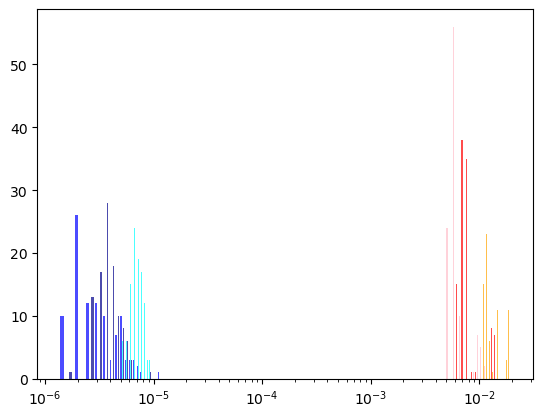

In [49]:
# Calculate MSE from anomaly set
predictions = model.predict(anomaly_features)
anomaly_mse = np.mean(np.power(anomaly_features - predictions, 2), axis=1)
print('Average MSE for for anomaly test set:', np.average(anomaly_mse))

# Plot histograms of normal validation vs. anomaly sets (MSEs)
fig, ax = plt.subplots(1,1)
plt.xscale("log")
ax.hist(normal_mse, bins=20, label='normal', color=['blue', 'cyan', 'darkblue'], alpha=0.7)
ax.hist(anomaly_mse, bins=20, label='anomaly', color=['red', 'orange', 'pink'], alpha=0.7)

4/4 [==============================] - 0s 49ms/step
Average MSE for normal test set: 4.923056101348393e-06


(array([[ 0.,  0., 15., 38., 35.,  1.,  1.,  0.,  0.,  0.,  0.,  8.,  7.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.],
        [ 0.,  0.,  0.,  0.,  0.,  0.,  0.,  0., 15., 23.,  6.,  1., 19.,
         11., 14.,  1.,  0.,  3., 11.,  1.],
        [24., 56., 10.,  0.,  0.,  1.,  7.,  5.,  2.,  0.,  0.,  0.,  0.,
          0.,  0.,  0.,  0.,  0.,  0.,  0.]]),
 array([0.00447546, 0.00523689, 0.00599832, 0.00675975, 0.00752118,
        0.00828261, 0.00904404, 0.00980547, 0.0105669 , 0.01132833,
        0.01208976, 0.01285119, 0.01361262, 0.01437405, 0.01513548,
        0.01589691, 0.01665834, 0.01741977, 0.0181812 , 0.01894263,
        0.01970406]),
 <a list of 3 BarContainer objects>)

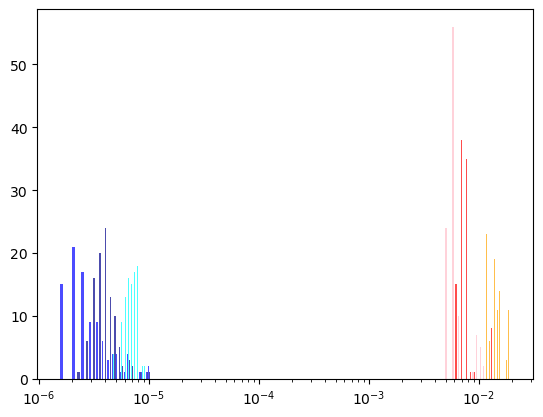

In [50]:
# Look at separation using test set
predictions = model.predict(x_test)
normal_mse = np.mean(np.power(x_test - predictions, 2), axis=1)
print('Average MSE for normal test set:', np.average(normal_mse))

# Plot histograms of normal test vs. anomaly sets (MSEs)
fig, ax = plt.subplots(1,1)
plt.xscale("log")
ax.hist(normal_mse, bins=20, label='normal', color=['blue', 'cyan', 'darkblue'], alpha=0.7)
ax.hist(anomaly_mse, bins=20, label='anomaly', color=['red', 'orange', 'pink'], alpha=0.7)

In [51]:
# If we're happy with the performance, save the model
model.save(keras_model_name + '.h5')

In [52]:
# Create a classifier (0 = normal, 1 = anomaly)
def detect_anomaly(x, model, threshold=0):
    pred = model.predict(x)
    mse = np.mean(np.power(x - pred, 2), axis=1)
    return mse > threshold

In [53]:
# Choose a threshold
anomaly_threshold = 8.e-04
# Perform classification on test set
pred_test = detect_anomaly(x_test, model, anomaly_threshold)
test_bool = []
for test in pred_test:
    true_anomaly = 0
    for value in test:
        if(int(value)):
            true_anomaly = 1
    test_bool.append(true_anomaly)

print(test_bool)

4/4 [==============================] - 0s 57ms/step
[0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0]


In [54]:
# Perform classification on anomaly set
pred_anomaly = detect_anomaly(anomaly_features, model, anomaly_threshold)
anomaly_bool = []
for anomaly in pred_anomaly:
    true_anomaly = 0
    for value in anomaly:
        if(int(value)):
            true_anomaly = 1
    anomaly_bool.append(true_anomaly)

print(anomaly_bool)

4/4 [==============================] - 0s 51ms/step
[1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1]


In [55]:
# Combine predictions into one long list and create a label list
pred = np.array(test_bool + anomaly_bool)
labels = ([0] * len(test_bool)) + ([1] * len(anomaly_bool))

[[105   0]
 [  0 105]]


Text(50.722222222222214, 0.5, 'Actual')

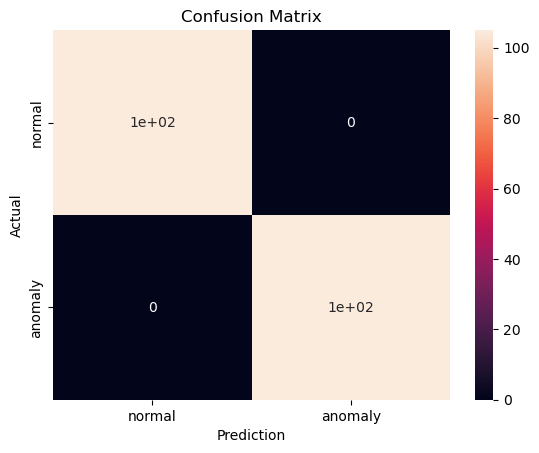

In [56]:
# Create confusion matrix
cm = confusion_matrix(labels, pred)
print(cm)
# Make confusion matrix pretty
df_cm = pd.DataFrame(cm, index=['normal', 'anomaly'], columns=['normal', 'anomaly'])
plt.figure()
sn.heatmap(df_cm, annot=True)
plt.title('Confusion Matrix')
plt.xlabel('Prediction')
plt.ylabel('Actual')